## NFQ and Pendulum problem 

The [inverted pendulum swingup problem](https://gymnasium.farama.org/environments/classic_control/pendulum//) is a classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

- The Action Space is a single action, the torque applied to the pendulum. It is a ndarray with shape (1,) representing the torque applied to free end of the pendulum.
- The Observation Space is a 3-dimensional space with the angle of the pendulum, the angular velocity and the torque applied.

1 - import the pendulum environment from Gymnasium and show it with a random policy

In [6]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'Pendulum-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym

pendulum = gym.make('Pendulum-v1', render_mode="rgb_array")

2- Create a random policy as a baseline:

In [15]:
# YOUR CODE HERE

# You have to create a function that get in input a state and provide a random float
# value (in the range [-2;2])

import numpy as np

pi_random = lambda s: pendulum.action_space.sample()

3 - Show the policy in action by rendering the environment several times after different decisions from the random policy:

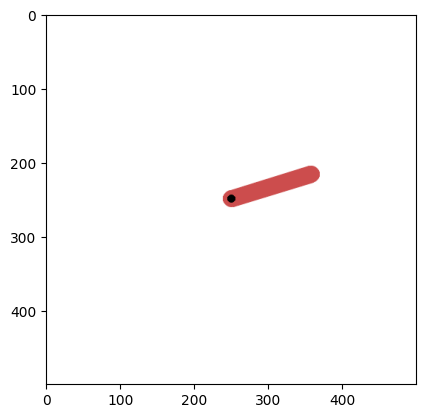

Step : 500 Action:  [0.11000645]


In [18]:
# YOUR CODE HERE

# You have to use a while loop in order to provide the current state to 
# the policy and then make a step in the environment using the action 
# provided by the policy. 
# Try to create a function (to be called "show_policy") 
# to be reused with other policies later.
# Hints: env.render() provides you an array representing 
# an image of the environment; plt.imshow() can be used to visualize 
# the image on the screen.

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=500):
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        steps = 0;
        while not done and steps < max_steps:
            action = pi(state);
            print(action)
            state, reward, done, _, _ = env.step(action)
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1
            print('Step :',steps, 'Action: ', action)
            time.sleep(0.01)

show_policy(pendulum, pi_random)

4 - Create a neural network as a function approximator for the Q-function.

In [19]:
# YOUR CODE HERE

# Add the code for a neural network using the PyTorch library

import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        
        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        # connecting the output layer    
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
            
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))

        # finally, for the output layer
        x = self.output_layer(x)
        
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions)
        new_states = torch.from_numpy(new_states)
        rewards = torch.from_numpy(rewards)
        is_terminals = torch.from_numpy(is_terminals)
        return states, actions, new_states, rewards, is_terminals



5 - Create a the code of two strategy for exploration and exploitation

In [20]:
# YOUR CODE HERE

# Add the code for an exploration strategy based on the epsilon-greedy algorithm

class EGreedyStrategy():
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_action(self, model, state):
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        # get a random number..
        if np.random.rand() > self.epsilon:
            # ...if greater than epsilon, act greedily
            action = np.argmax(q_values)
        else: 
            # ...otherwise, act randomly
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = (action != np.argmax(q_values))
        return action

In [21]:
# YOUR CODE HERE

# Add the code for a exploitation strategy based on the greedy algorithm in order to evaluate your policy

class GreedyStrategy():
    
    def select_action(self, model, state):
        q_values = model(state).detach()
        q_values = q_values.data.numpy().squeeze()
        return np.argmax(q_values)



6 - Write the code of the NFQ algorithm

In [22]:
# YOUR CODE HERE

# Add the code for the NFQ algorithm

import random 
import torch
import torch.optim as optim
from itertools import count

class NFQ():
    def __init__(self, env, model, optimizer, train_strategy, eval_strategy,
                 seed, batch_size, epochs):
        
        # set the seed
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        # store the objects
        self.env = env
        self.model = model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch_size = batch_size
        self.epochs = epochs

    def train(self, gamma, max_minutes, max_episodes, goal_reward):

        # timing variables
        training_start = time.time()

        self.gamma = gamma

        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        # vector to collect the experience
        self.experiences = []

        result = np.empty((max_episodes, 4))
        result[:] = np.nan
            
        training_time = 0
            
        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()

            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)
                
            # reset the environment before starting the episode  
            state, is_terminal = self.env.reset()[0], False

            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience batch
                state, is_terminal = self.interaction_step(state)

                # if the experience is enough, then optimize the model 
                if len(self.experiences) >= self.batch_size:

                    # load the experiences as tensors for training
                    experiences = np.array(self.experiences, dtype=object)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    experiences = self.model.load(batches)

                    # optimize the model for a number of epochs
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                        
                    # reset the experience batch
                    self.experiences.clear()
                if is_terminal:
                    break
                
            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
                
            # average stats over some recent episodes
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            # report results
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
                
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
                
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)

            # conclude training if we have met any of the stopping conditions 
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print('--> reached_max_minutes ')
                if reached_max_episodes: print('--> reached_max_episodes ')
                if reached_goal_mean_reward: print('--> reached_goal_mean_reward ')
                break
            
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
            
        return result, final_eval_score, final_eval_std, training_time

    def optimize_model(self, experiences):
            
        # convert the experiences into separate arrays for each element
        states, actions, rewards, next_states, is_terminals = experiences

        # get the batch size
        batch_size = len(is_terminals)
            
        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants 
        q_sp = self.model(next_states).detach()
            
        # get the max value of the next state
        max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
            
        # one important step, often overlooked, is to ensure 
        # terminal states are grounded to zero
        max_a_q_sp *= (1 - is_terminals)
            
        # calculate the target 
        target_q_sa = rewards + self.gamma * max_a_q_sp
            
        # finally, we get the current estimate of Q(s,a)
        q_sa = self.model(states).gather(1, actions)

        # create the errors
        td_errors = q_sa - target_q_sa
            
        # calculate the loss, and optimize the online network
        value_loss = td_errors.pow(2).mul(0.5).mean()

        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()

    def interaction_step(self, state):

        # interact with environment using the exploration policy
        action = self.train_strategy.select_action(self.model, state)

        # collect an experience tuple as usual
        new_state, reward, is_terminal, is_truncated, info = self.env.step(action)
        
        # a failure is defined as follows
        is_failure = is_terminal and not is_truncated

        # collect the experience and store it in the batch 
        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)

        # update episode stats
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        
        return new_state, is_terminal
    
    def evaluate(self, n_episodes=1):

        # create a list of returns of each episode
        rs = []

        # loop over the episodes
        for _ in range(n_episodes):

            # reset the environment before starting the episode
            s, d = self.env.reset()[0], False

            # initialize the return
            rs.append(0)

            # interact with the environment until the episode is done 
            while(True):

                # interact with environment using the exploitation policy
                a = self.eval_strategy.select_action(self.model, s)

                # collect an experience tuple as usual
                s, r, d, t, _ = self.env.step(a)

                # add the reward to the return of the episode
                rs[-1] += r

                if d or t:
                    break
                
        return np.mean(rs), np.std(rs)

6 - Apply NFQ to the pendulum environment. 

In [29]:
gamma = 0.99

max_minutes = 20
max_episodes = 1000
goal_reward = 10

batch_size = 1024
epochs = 40
seed = 12

nS, nA = pendulum.observation_space.shape[0], 1

print('Training started...')

model = FCQ(nS, nA, hidden_dims=(512,128))
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
train_strategy = EGreedyStrategy(epsilon=0.5)
eval_strategy = GreedyStrategy()
    
agent = NFQ(pendulum, model, optimizer, train_strategy, eval_strategy, seed, batch_size, epochs)
result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)
    
print('...training complete.')
print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))

Training started...


TypeError: len() of unsized object

**3 - show the learning curves** 

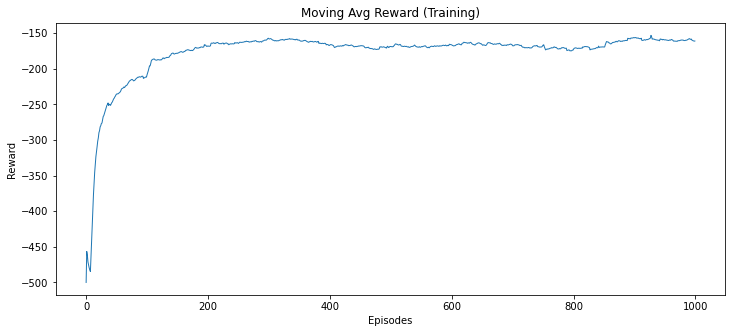

In [29]:
import matplotlib.pyplot as plt

steps, train_reward, eval_score, time = result.T

plt.figure(figsize=(12,5))
plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

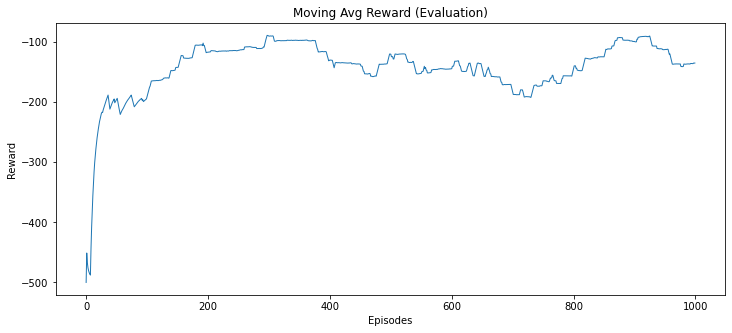

In [30]:
plt.figure(figsize=(12,5))
plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

**4 - show the policy behaviour**

In [40]:
def show_policy(agent, env, steps=100):
    plt.axis('off')
    observation = env.reset()
    done = False
    for _ in range(steps): 
        action = agent.eval_strategy.select_action(agent.model, observation)
        observation, _, done, _ = env.step(action)
        if done: 
            observation = env.reset()
        display.clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array'))
        plt.show()   
    env.close()
    return

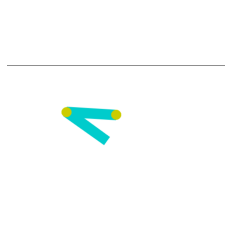

In [41]:
env = gym.make('Acrobot-v1');
show_policy(agent, env, steps=200)